In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM, using both Adjusted Close and Volume Parameters
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Merge
from keras.layers import Activation, Dropout
from keras.metrics import mean_squared_error

# Import fix for Tensorflow 1.0 control flow ops w/ Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_1

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close    Volume
0     0  1995-01-03   4.562831  11896800
1     1  1995-01-04   4.562831  10144200
2     2  1995-01-05   4.574014  10977600
3     3  1995-01-06   4.551648   9777000
4     4  1995-01-09   4.506914   8478000
---
      Item        Date  Adj_Close    Volume
5147  5147  2015-06-12  25.703041  22170600
5148  5148  2015-06-15  25.534127  28498700
5149  5149  2015-06-16  25.543511  27569500
5150  5150  2015-06-17  25.590433  36548300
5151  5151  2015-06-18  25.902742  37680700


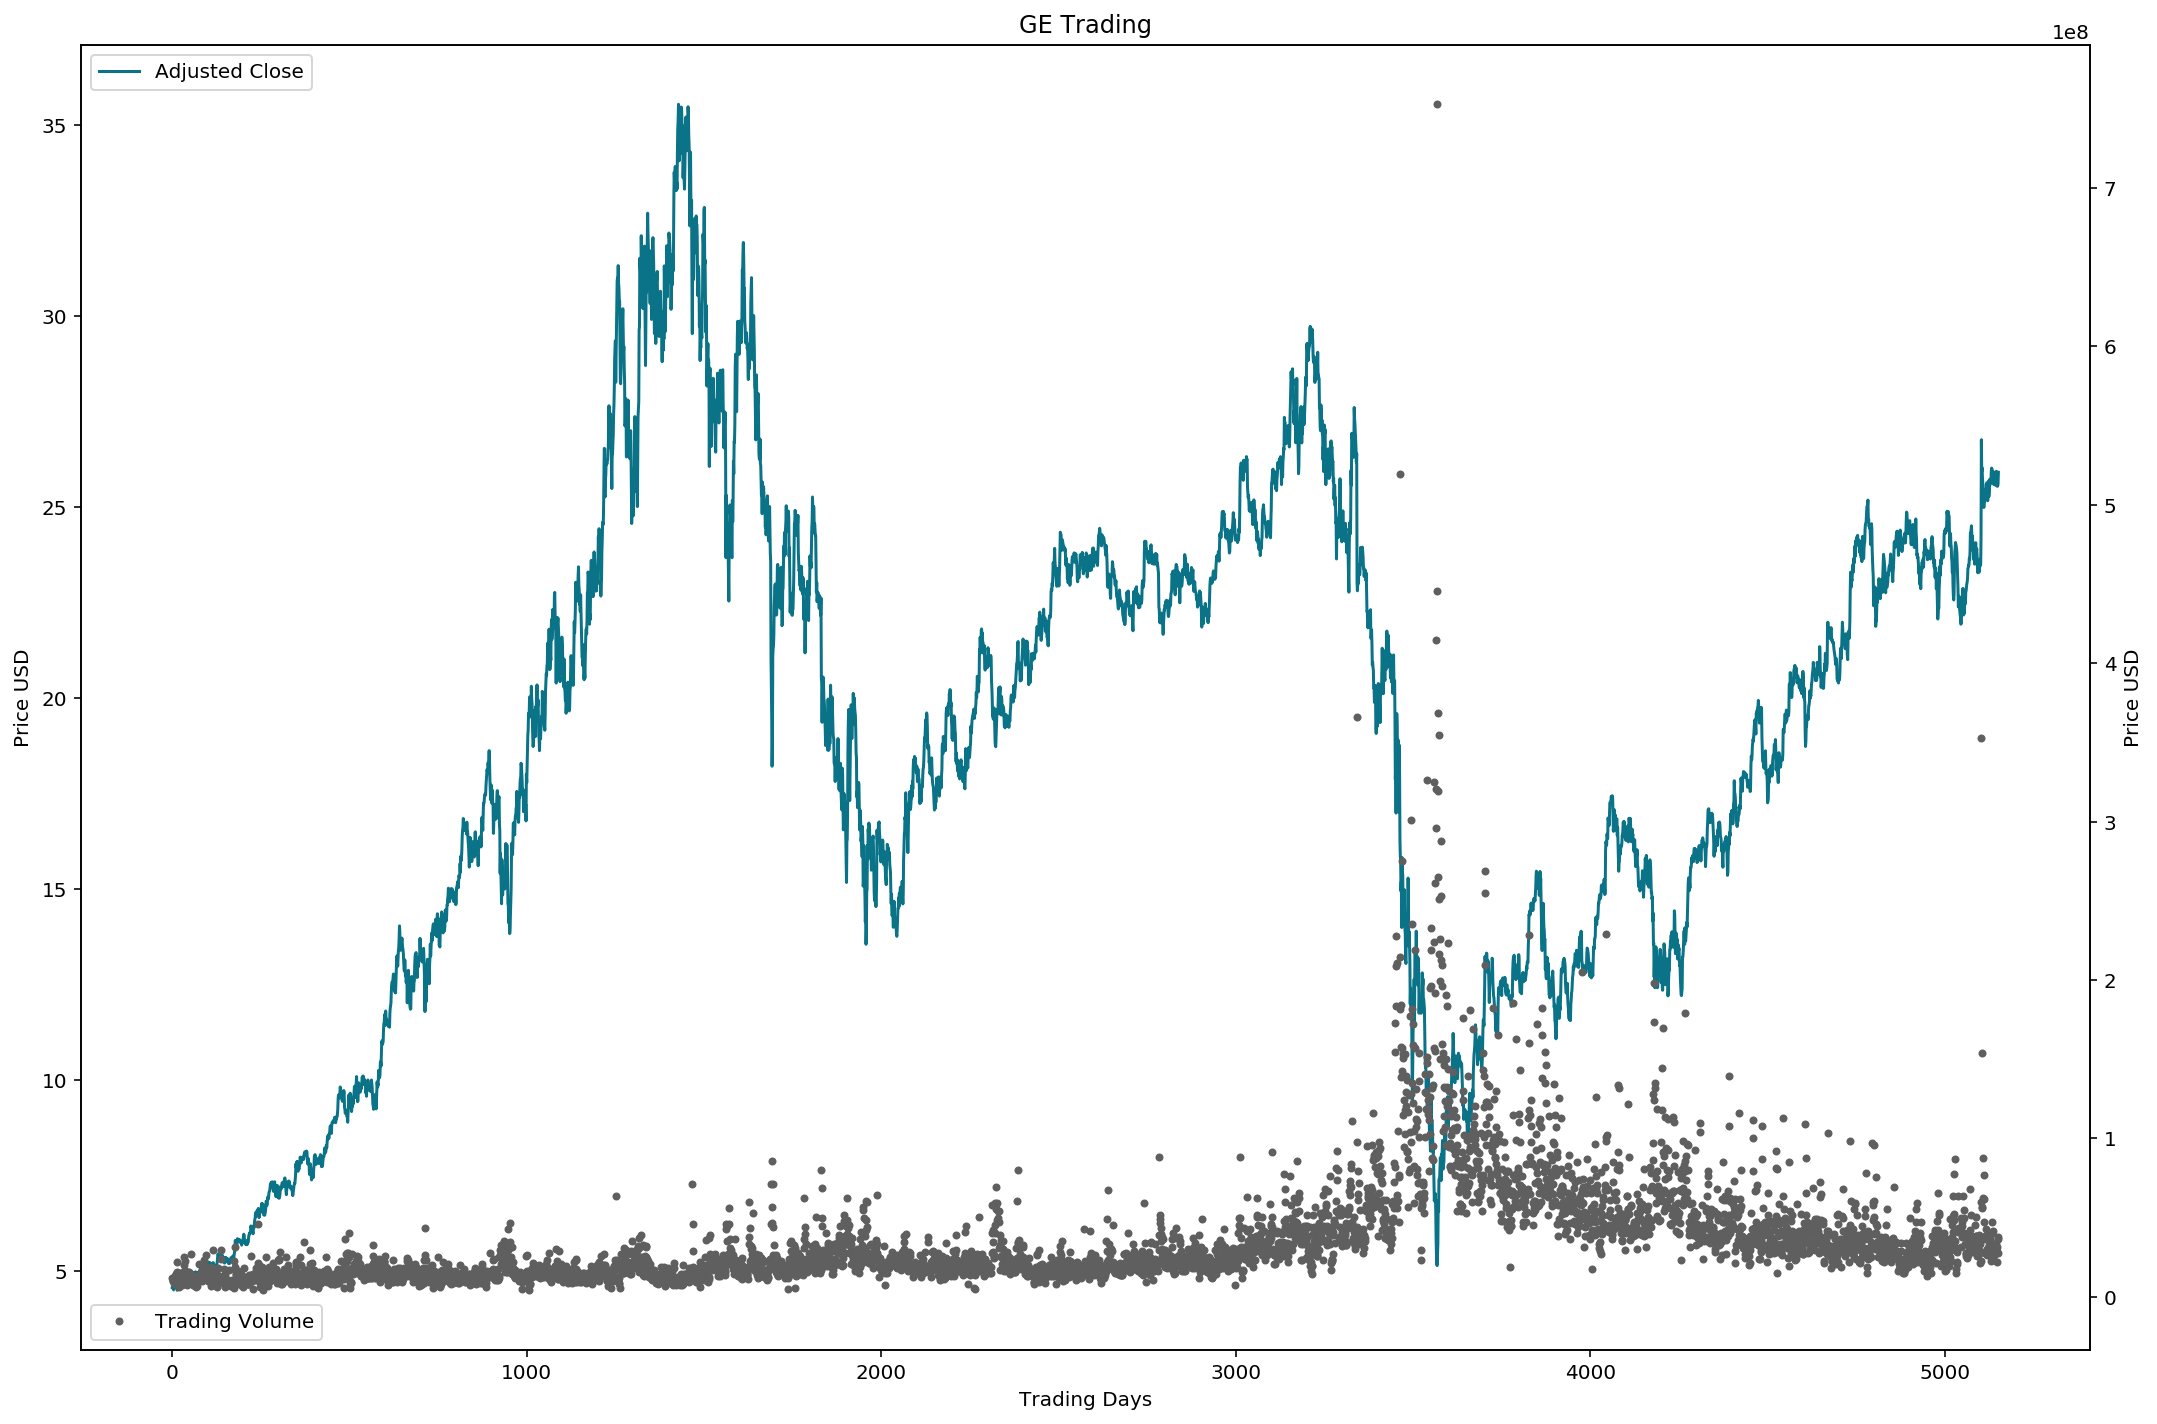

In [4]:
# Plot Basic Data
fig, ax1 = plt.subplots()
# Axis 1 - Adjusted Close
ax1.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')
# Set X Axis label
ax1.set_xlabel('Trading Days')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(stock_df['Item'], stock_df['Volume'], 'r.', color='#5f5f5f', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

# Add title and legend
ax1.set_title(base_ticker + ' Trading')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()

In [5]:
#Create numpy arrays for features and targets
day_all = []
vol_all = []
close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    day_all.append([(row['Item'])])
    vol_all.append([(row['Volume'])])
    close_all.append([(row['Adj_Close'])])

pprint(close_all)

[[4.562831],
 [4.562831],
 [4.574014],
 [4.551648],
 [4.506914],
 [4.540464],
 [4.607565],
 [4.596381],
 [4.652299],
 [4.708215],
 [4.652299],
 [4.674665],
 [4.562831],
 [4.562831],
 [4.495731],
 [4.506914],
 [4.540464],
 [4.562831],
 [4.518098],
 [4.574014],
 [4.607565],
 [4.574014],
 [4.585198],
 [4.663482],
 [4.652299],
 [4.652299],
 [4.652299],
 [4.674665],
 [4.663482],
 [4.708215],
 [4.708215],
 [4.797683],
 [4.842416],
 [4.797683],
 [4.82005],
 [4.931883999999999],
 [4.954251],
 [4.898333],
 [4.797683],
 [4.898333],
 [4.878951],
 [4.788809],
 [4.777541],
 [4.755005000000001],
 [4.743737],
 [4.800076],
 [4.800076],
 [4.93529],
 [4.924022],
 [4.957826],
 [4.845147],
 [4.946557],
 [4.890219],
 [4.878951],
 [4.901486],
 [4.924022],
 [4.9127540000000005],
 [4.957826],
 [4.924022],
 [4.946557],
 [4.957826],
 [4.93529],
 [4.867683],
 [4.924022],
 [4.946557],
 [4.946557],
 [4.980361],
 [4.946557],
 [4.957826],
 [4.93529],
 [4.93529],
 [4.957826],
 [4.856415],
 [4.867683],
 [4.93529],
 [4

In [6]:
# Reshape into t and t+1
look_back_a = 1 
look_back_b = 10 
tt_split = (1.0-.315)

X_vol_train, y_vol_train, X_vol_test, y_vol_test, vol_bounds = \
    util.create_dataset(vol_all, look_back_a, tt_split, True)
Xa_close_train, ya_close_train, Xa_close_test, ya_close_test, close_bounds = \
    util.create_dataset(close_all, look_back_a, tt_split, True)
Xb_close_train, yb_close_train, Xb_close_test, yb_close_test, cb = \
    util.create_dataset(close_all, look_back_b, tt_split, True)
    
pprint(Xb_close_train)
print('--')
pprint(yb_close_train)

array([[[ 0.00216189],
        [ 0.00216189],
        [ 0.00252219],
        ..., 
        [ 0.00324283],
        [ 0.00504444],
        [ 0.006846  ]],

       [[ 0.00216189],
        [ 0.00252219],
        [ 0.00180158],
        ..., 
        [ 0.00504444],
        [ 0.006846  ],
        [ 0.00504444]],

       [[ 0.00252219],
        [ 0.00180158],
        [ 0.0003603 ],
        ..., 
        [ 0.006846  ],
        [ 0.00504444],
        [ 0.00576505]],

       ..., 
       [[ 0.23616175],
        [ 0.24469714],
        [ 0.24445547],
        ..., 
        [ 0.26765412],
        [ 0.25702138],
        [ 0.26257943]],

       [[ 0.24469714],
        [ 0.24445547],
        [ 0.24107233],
        ..., 
        [ 0.25702138],
        [ 0.26257943],
        [ 0.24445547]],

       [[ 0.24445547],
        [ 0.24107233],
        [ 0.23358108],
        ..., 
        [ 0.26257943],
        [ 0.24445547],
        [ 0.24518039]]])
--
array([[ 0.00504444],
       [ 0.00576505],
       [ 0.00216

In [9]:
pprint(ya_close_test)

array([[ 0.24445547],
       [ 0.24518039],
       [ 0.24179728],
       ..., 
       [ 0.67783347],
       [ 0.67813581],
       [ 0.67964759]])


In [78]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Set up hyperparameters
batch_size = 1
epochs = 1 # 200
n_nodes = [16,32]

# Create three branches of LSTM model

# Create LSTM Adjusted Close network - 1 day tracker stacked
model_a = Sequential()
model_a.add(LSTM(n_nodes[0],batch_input_shape=(batch_size, look_back_a, 1),return_sequences=True))
model_a.add(Dropout(0.2))
model_a.add(LSTM(n_nodes[1],return_sequences=False)) #, dropout_W=0.2))
model_a.add(Dropout(0.2))
model_a.add(Dense(output_dim=1))
model_a.add(Activation('linear'))

# Create LSTM Adjusted Close network - 10 day tracker
model_b = Sequential()
model_b.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back_b, 1)))
model_b.add(Dense(1))

# Create LSTM Volume network - 1 day tracker
model_c = Sequential()
model_c.add(LSTM(n_nodes[0], batch_input_shape=(batch_size, look_back_a, 1)))
model_c.add(Dense(1))
model_c.add(Activation('linear'))

# Create Merged Model
merged_model = Merge([model_a, model_c], mode='sum', concat_axis=1)

# Create final composite model
final_model = Sequential()
final_model.add(merged_model)
# Potential add layers
final_model.add(Dense(1))
# Activation layer?

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.compile(loss='mean_squared_error', optimizer='adam')
print 'compilation time : ', time.time() - start

compilation time :  4.61372303963


In [79]:
# Format inputs
train_inputs = [Xa_close_train, X_vol_train]

# Train the model
final_model.fit(train_inputs, 
                ya_close_train, 
                nb_epoch=epochs, 
                batch_size=batch_size, 
                verbose=2,
                validation_split=0.05)

Train on 3351 samples, validate on 177 samples
Epoch 1/1
28s - loss: 0.0084 - val_loss: 7.1186e-04


In [80]:
# Format inputs
test_inputs = [Xa_close_test, X_vol_test]

# Generate predictions for training
testPredict = final_model.predict(test_inputs, batch_size=batch_size)
#testPredict = util.predict_sequences(final_model, test_inputs)
pprint(testPredict)

array([[ 0.27227807],
       [ 0.25600019],
       [ 0.25477254],
       ..., 
       [ 0.65840858],
       [ 0.65451694],
       [ 0.65460825]], dtype=float32)


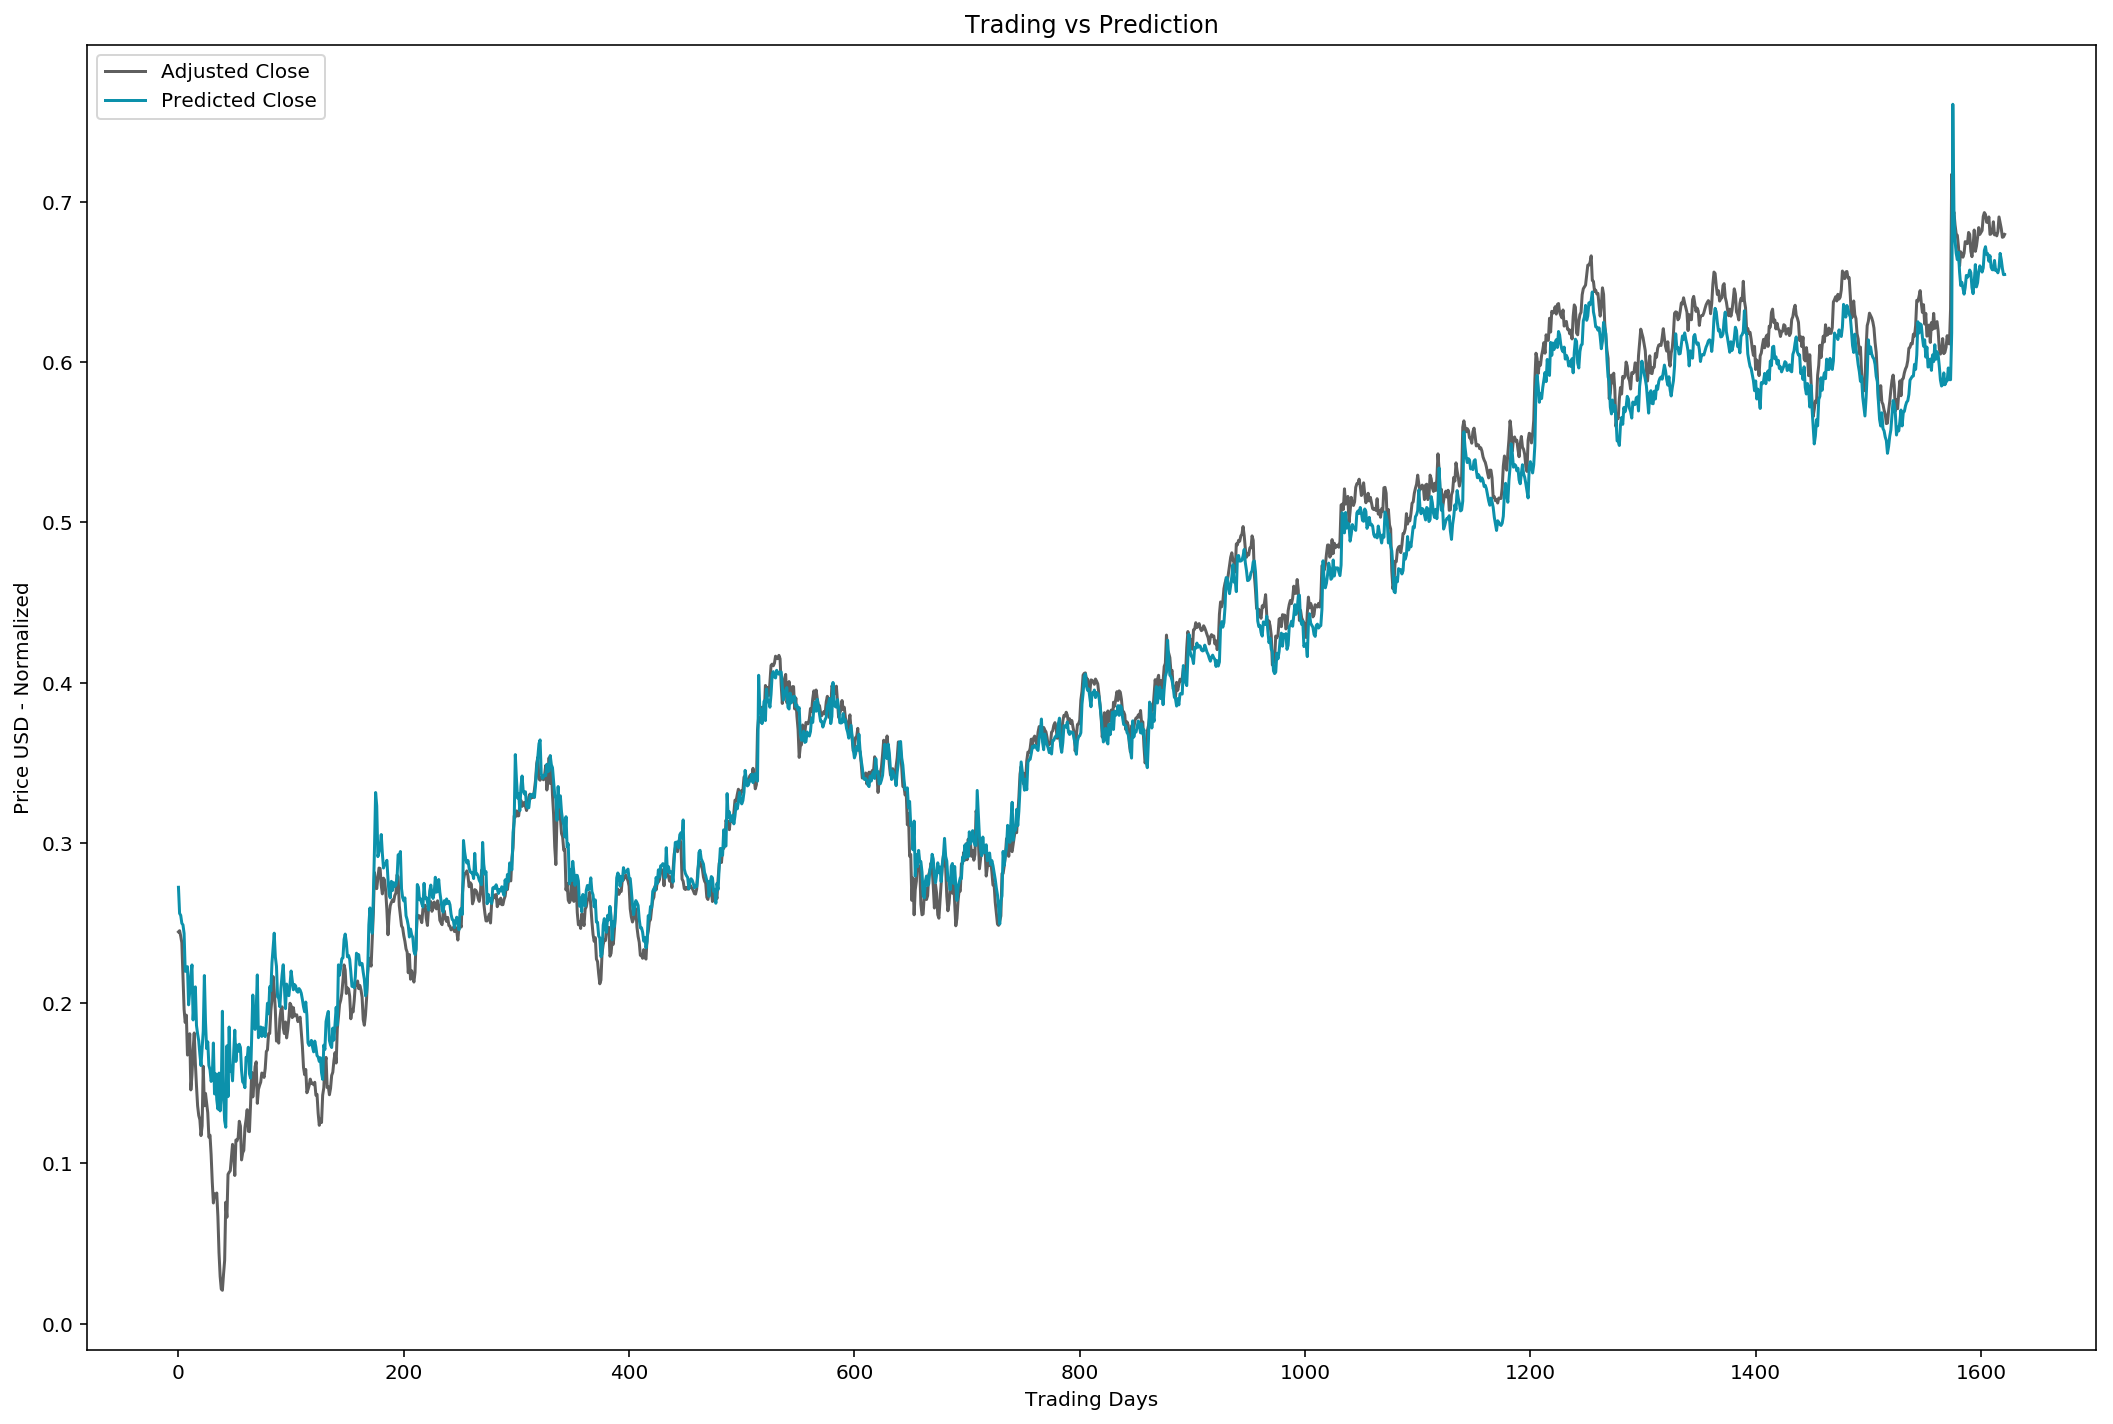

In [81]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(ya_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [82]:
# The mean squared error
testScore = final_model.evaluate(test_inputs, ya_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.00045 MSE (0.02127 RMSE)


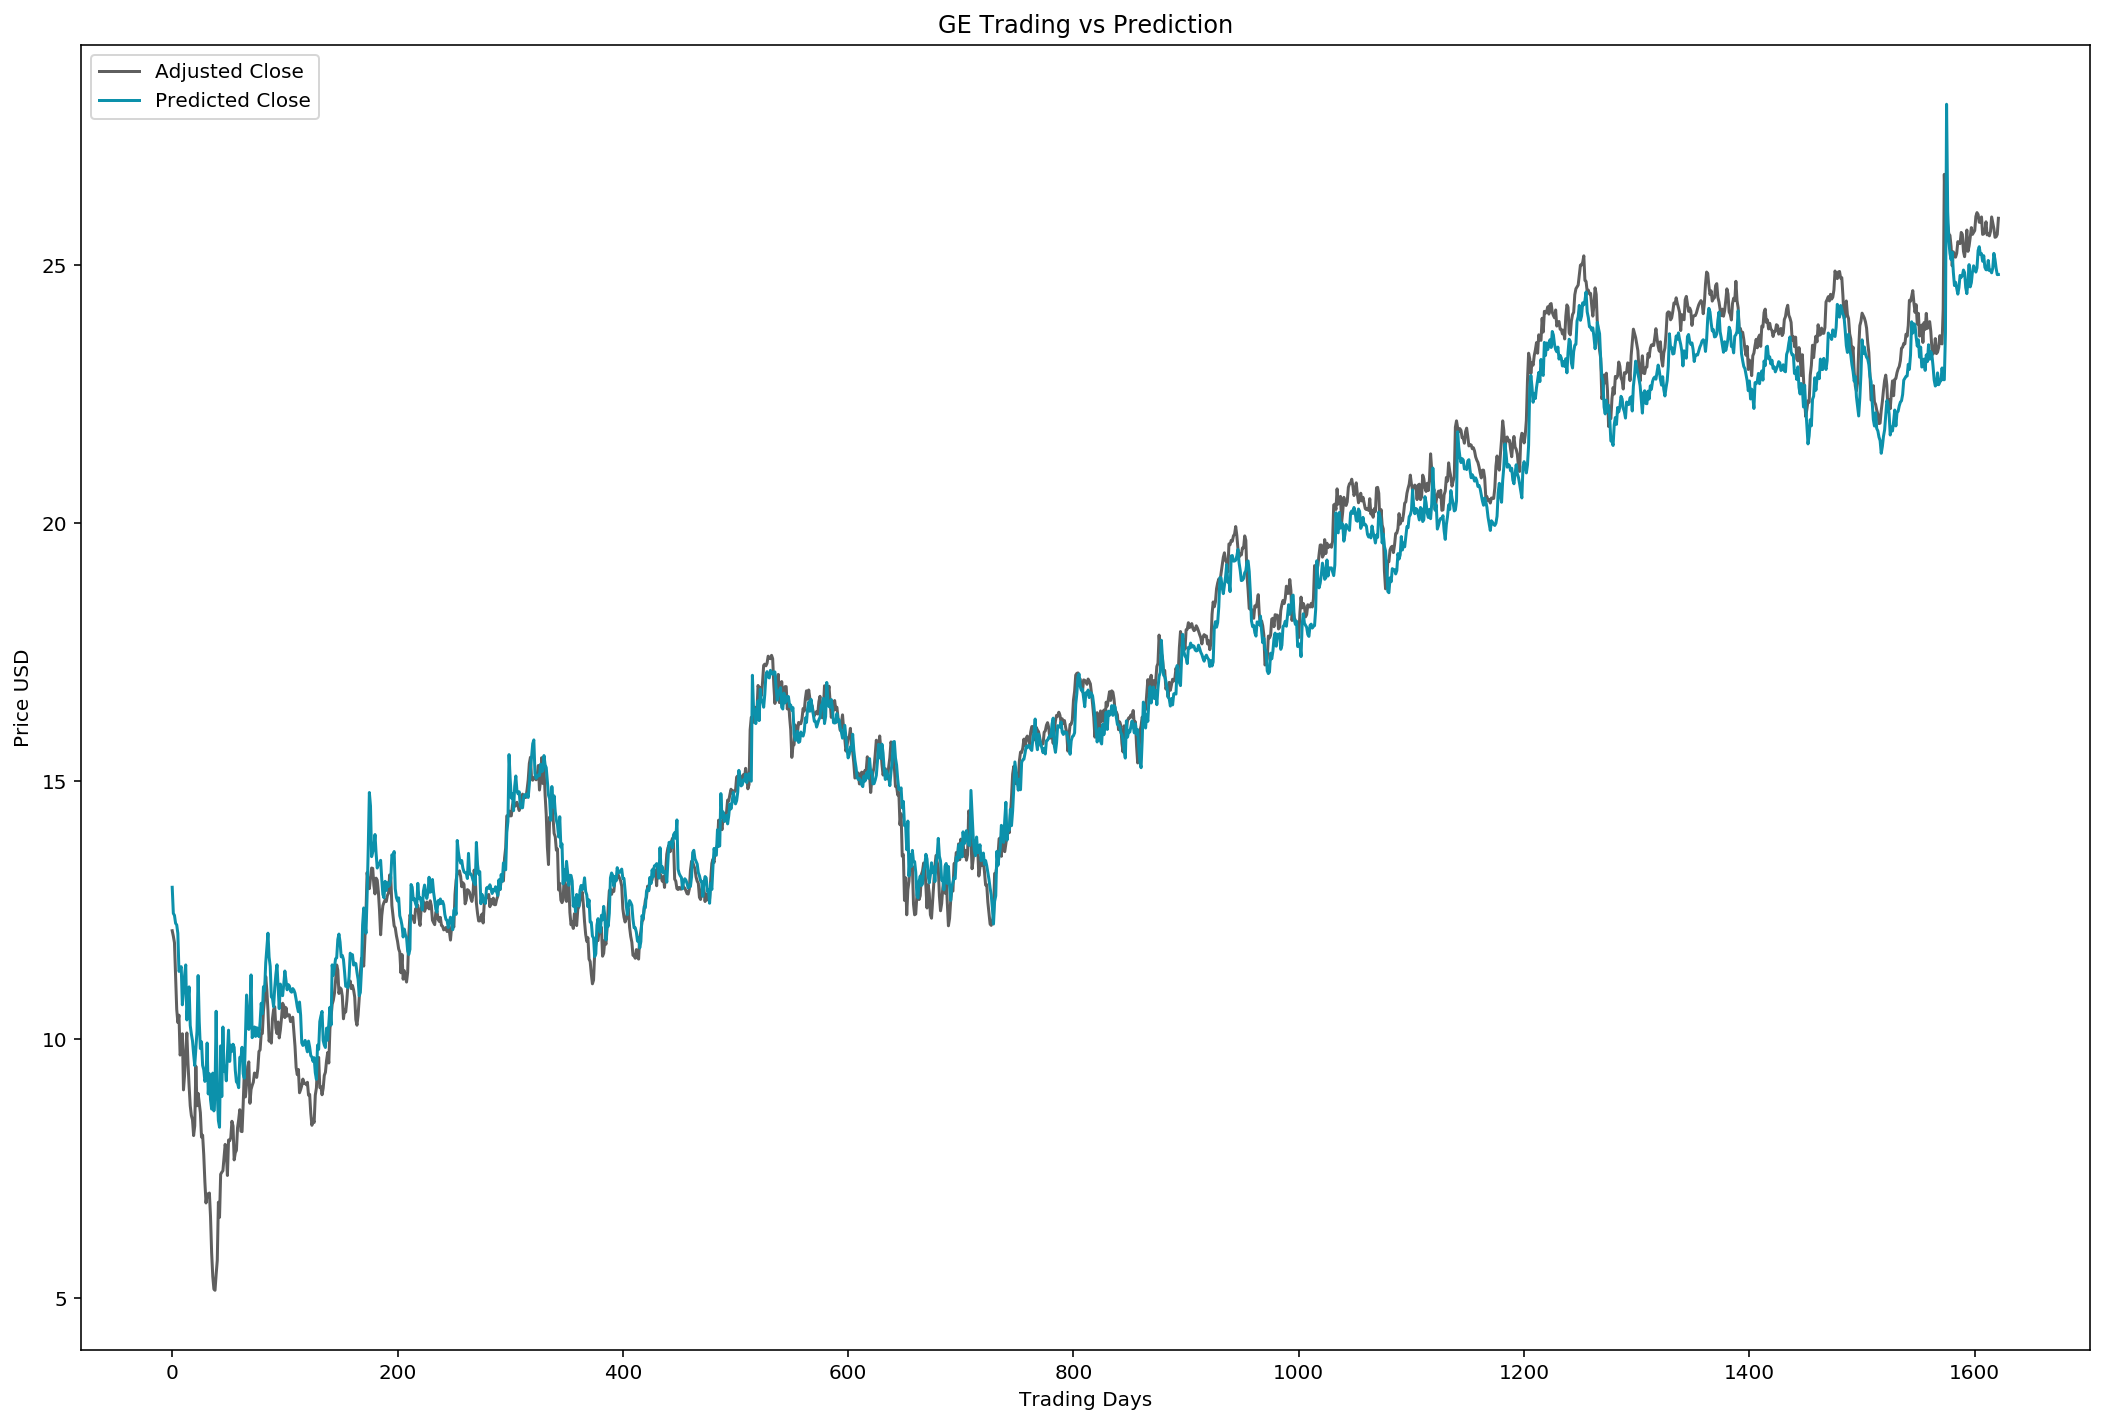

In [83]:
# Plot the predictions
close_plot = close_all[-ya_close_test.shape[0]:]

pred_seq = np.array(testPredict)
#pprint(pred_seq)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)
#pprint(preds_seq_plot)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

# Log of Results:
Epochs: 1 Lookback: 1

### SPY
Test Score: 0.00027 MSE (0.01640 RMSE)

Test Score: 0.00132 MSE (0.03630 RMSE) no activation

Test Score: 0.00016 MSE (0.01279 RMSE) *both activation

### GE
Test Score: 0.00061 MSE (0.02462 RMSE)

### MSFT
Test Score: 0.00022 MSE (0.01481 RMSE)


### AAPL
Test Score: 0.00103 MSE (0.03217 RMSE)
